<a href="https://colab.research.google.com/github/maweigert/stardist-i2k/blob/main/notebooks/technical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**If on Google Colab, first do this:**

Click on `Runtime` > `Change runtime type` and select `GPU` as `Hardware accelerator`.

# CSBDeep

Technical infrastructure that powers CSBDeep and StarDist under the hood.

#### Basic setup for this notebook

In [ ]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False

if COLAB:
    import sys
    !{sys.executable} -m pip install csbdeep stardist

In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Keras with TensorFlow 1 & 2

In [2]:
from csbdeep.utils.tf import keras_import

keras = keras_import()
# equivalent to either:
# - "import keras"                 # if using TensorFlow 1.x and separate Keras package
# - "from tensorflow import keras" # if using TensorFlow 2.x with integrated Keras

# can also do specific imports, e.g.:
Input, Dense = keras_import('layers', 'Input','Dense')
assert Input == keras.layers.Input and Dense == keras.layers.Dense

## Blocks and Nets

In [3]:
from csbdeep.internals.nets import common_unet, custom_unet
from csbdeep.internals.blocks import unet_block, resnet_block

model = common_unet(residual=False,n_channel_out=2)((128,128,3))
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
down_level_0_no_0 (Conv2D)      (None, 128, 128, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
down_level_0_no_1 (Conv2D)      (None, 128, 128, 16) 2320        down_level_0_no_0[0][0]          
__________________________________________________________________________________________________
max_0 (MaxPooling2D)            (None, 64, 64, 16)   0           down_level_0_no_1[0][0]          
_______________________________________________________________________________________

In [4]:
x = inputs = Input((128,128,3))
x = resnet_block(64)(x)
x = resnet_block(128, pool=(2,2))(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
x = outputs = Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 64) 256         input_1[0][0]                    
_______________________________________________________________________________________

## BaseConfig & BaseModel

In [5]:
from csbdeep.models import BaseModel, BaseConfig

In [6]:
BaseConfig()

BaseConfig(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5')

In [7]:
class MyConfig(BaseConfig):
    def __init__(self, my_parameter, **kwargs):
        super().__init__(**kwargs)
        self.my_parameter = my_parameter

config = MyConfig(my_parameter=42)
config

MyConfig(axes='YXC', my_parameter=42, n_channel_in=1, n_channel_out=1, n_dim=2, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5')

In [8]:
class MyModel(BaseModel):    
    @property
    def _config_class(self):
        return MyConfig
    
    def _build(self):
        pass

In [9]:
# demo: delete model folder if it already exists
%rm -rf models/my_model

In [10]:
# create model folder and persist config
model = MyModel(config, 'my_model', basedir='models')
model

MyModel(my_model): YXC → YXC
├─ Directory: /home/uwe/research/misc/i2k-2020/models/my_model
└─ MyConfig(axes='YXC', my_parameter=42, n_channel_in=1, n_channel_out=1, n_dim=2, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5')

In [11]:
%ls models/my_model

config.json


In [12]:
%cat models/my_model/config.json

{"n_dim": 2, "axes": "YXC", "n_channel_in": 1, "n_channel_out": 1, "train_checkpoint": "weights_best.h5", "train_checkpoint_last": "weights_last.h5", "train_checkpoint_epoch": "weights_now.h5", "my_parameter": 42}

In [13]:
# load model from folder (config and possibly trained weights)
model = MyModel(None, 'my_model', basedir='models')
model

Couldn't find any network weights (*.h5, *.hdf5) to load.


MyModel(my_model): YXC → YXC
├─ Directory: /home/uwe/research/misc/i2k-2020/models/my_model
└─ MyConfig(axes='YXC', my_parameter=42, n_channel_in=1, n_channel_out=1, n_dim=2, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5')

BaseModel has more to offer, some is shown below...

In [14]:
[a for a in dir(model) if not a.startswith('__')]

['_abc_impl',
 '_axes_out',
 '_build',
 '_check_normalizer_resizer',
 '_checkpoint_callbacks',
 '_config_class',
 '_find_and_load_weights',
 '_make_permute_axes',
 '_model_prepared',
 '_repr_extra',
 '_set_logdir',
 '_training_finished',
 '_update_and_check_config',
 'basedir',
 'config',
 'export_TF',
 'from_pretrained',
 'keras_model',
 'load_weights',
 'logdir',
 'name']

## Registry for pretrained models

In [15]:
from stardist.models import StarDist2D
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [16]:
StarDist2D.from_pretrained('Versatile (fluorescent nuclei)')

Found model '2D_versatile_fluo' with alias 'Versatile (fluorescent nuclei)' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


StarDist2D(2D_versatile_fluo): YXC → YXC
├─ Directory: None
└─ Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_background_reg=0.0001, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=800, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=[1, 0.2], train_n_val_patches=None, train_patch_size=[256, 256], train_reduce_lr={'factor': 0.5, 'patience': 80, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=400, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=[3, 3], unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=[2, 2], unet_prefix='', use_gp

In [17]:
MyModel.from_pretrained()

There are 0 registered models for 'MyModel'


In [18]:
from csbdeep.models import register_model, register_aliases

register_model(MyModel,   'my_model', 'http://example.com/my_model.zip', '<hash>')
register_aliases(MyModel, 'my_model', 'My minimal model', 'Another name for my model')

In [19]:
MyModel.from_pretrained()

There is 1 registered model for 'MyModel':

Name         Alias(es)
────         ─────────
'my_model'   'My minimal model', 'Another name for my model'


## Example: U-Net model for multi-class semantic segmentation

Note that the focus is on demonstrating certain concepts rather than being a good/complete segmentation approach.

### Helper

In [20]:
from glob import glob
from tqdm import tqdm
from tifffile import imread
from pathlib import Path
from skimage.segmentation import find_boundaries

def crop(u,shape=(256,256)):
    """Crop central region of given shape"""
    return u[tuple(slice((s-m)//2,(s-m)//2+m) for s,m in zip(u.shape,shape))]

def to_3class_label(lbl, onehot=True):
    """Convert instance labeling to background/inner/outer mask"""
    b = find_boundaries(lbl,mode='outer')
    res = (lbl>0).astype(np.uint8)
    res[b] = 2
    if onehot:
        res = keras.utils.to_categorical(res,num_classes=3).reshape(lbl.shape+(3,))
    return res

def dice_bce_loss(n_labels):
    """Combined crossentropy and dice loss"""
    K = keras.backend
    def _sum(a):
        return K.sum(a, axis=(1,2), keepdims=True)
    def dice_coef(y_true, y_pred):
        return (2 * _sum(y_true * y_pred) + K.epsilon()) / (_sum(y_true) + _sum(y_pred) + K.epsilon())
    def _loss(y_true, y_pred):
        dice_loss = 0
        for i in range(n_labels):
            dice_loss += 1-dice_coef(y_true[...,i], y_pred[...,i])
        return dice_loss/n_labels + K.categorical_crossentropy(y_true, y_pred)
    return _loss

def datagen(X,Y,batch_size,seed=0):
    """Simple data augmentation"""
    g = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True,
                                                     rotation_range=10, shear_range=10, fill_mode='reflect')
    assert seed is not None
    gX = g.flow(X, batch_size=batch_size, seed=seed)
    gY = g.flow(Y, batch_size=batch_size, seed=seed)
    while True:
        yield gX.next(), gY.next()

### Data

In [21]:
from csbdeep.utils import download_and_extract_zip_file, normalize

download_and_extract_zip_file(
    url       = 'https://github.com/mpicbg-csbd/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files found, nothing to download.


In [22]:
# load and crop out central patch (for simplicity)
X       = [crop(imread(x)) for x in sorted(glob('data/dsb2018/train/images/*.tif'))]
Y_label = [crop(imread(y)) for y in sorted(glob('data/dsb2018/train/masks/*.tif'))]

# normalize input image and convert label image to 3-class segmentation mask
X = [normalize(x,1,99.8) for x in tqdm(X)]
Y = [to_3class_label(y) for y in tqdm(Y_label)]

# convert to numpy arrays
X, Y, Y_label = np.expand_dims(np.stack(X),-1), np.stack(Y), np.stack(Y_label)

100%|██████████| 447/447 [00:01<00:00, 439.93it/s]


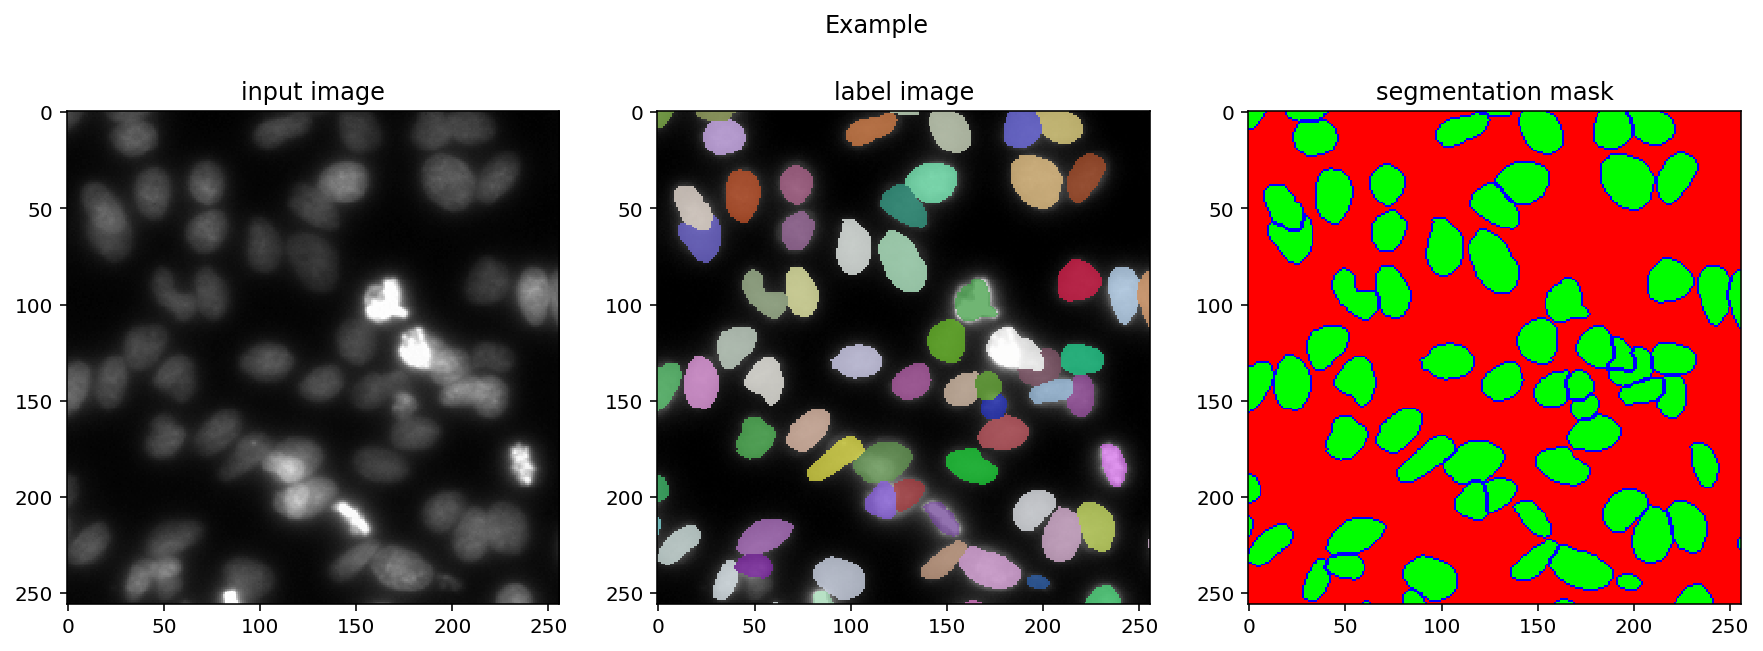

In [23]:
from stardist import render_label

i = 15
lbl_show = render_label(Y_label[i], img=X[i,...,0], alpha=0.75)

fig, (a0,a1,a2) = plt.subplots(1,3,figsize=(15,5))
a0.imshow(X[i,...,0],cmap='gray');  a0.set_title('input image')
a1.imshow(lbl_show);                a1.set_title('label image')
a2.imshow(Y[i]);                    a2.set_title('segmentation mask')
fig.suptitle("Example")
None;

### Model

In [24]:
from csbdeep.data import PadAndCropResizer
from csbdeep.utils import axes_check_and_normalize
from csbdeep.utils.tf import IS_TF_1, CARETensorBoardImage

if IS_TF_1:
    raise NotImplementedError("For sake of simplicity, this example only works with TensorFlow 2.x")

    
class SegConfig(BaseConfig):
    def __init__(self, unet_depth, **kwargs):
        super().__init__(**kwargs)
        self.unet_depth = unet_depth


class SegModel(BaseModel):    
    @property
    def _config_class(self):
        return SegConfig
    
    def _build(self):
        return common_unet(n_depth=self.config.unet_depth,
                           n_first=32, residual=False,
                           n_channel_out=self.config.n_channel_out,
                           last_activation='softmax')((None,None,self.config.n_channel_in))

    def _prepare_for_training(self, validation_data, lr):
        assert self.config.n_channel_out > 1        
        self.keras_model.compile(optimizer=keras.optimizers.Adam(lr),
                                 loss=dice_bce_loss(self.config.n_channel_out),
                                 metrics=['categorical_crossentropy','accuracy'])
        self.callbacks = self._checkpoint_callbacks()
        self.callbacks.append(keras.callbacks.TensorBoard(log_dir=str(self.logdir/'logs'),
                                                          write_graph=False, profile_batch=0))
        self.callbacks.append(CARETensorBoardImage(model=self.keras_model, data=validation_data,
                                                   log_dir=str(self.logdir/'logs'/'images'),
                                                   n_images=3, prob_out=False))
        self._model_prepared = True
        
    def train(self, X,Y, validation_data, lr, batch_size, epochs, steps_per_epoch):
        if not self._model_prepared:
            self._prepare_for_training(validation_data, lr)
        training_data = datagen(X,Y,batch_size)
        history = self.keras_model.fit(training_data, validation_data=validation_data,
                                       epochs=epochs, steps_per_epoch=steps_per_epoch,
                                       callbacks=self.callbacks, verbose=1)
        self._training_finished()
        return history
    
    def predict(self, img, axes=None, normalizer=None, resizer=PadAndCropResizer()):
        normalizer, resizer = self._check_normalizer_resizer(normalizer, resizer)
        axes_net = self.config.axes
        if axes is None:
            axes = axes_net
        axes = axes_check_and_normalize(axes, img.ndim)
        axes_net_div_by = tuple((2**self.config.unet_depth if a in 'XYZ' else 1) for a in axes_net)
        x = self._make_permute_axes(axes, axes_net)(img)
        x = normalizer(x, axes_net)
        x = resizer.before(x, axes_net, axes_net_div_by)        
        pred = self.keras_model.predict(x[np.newaxis])[0]
        pred = resizer.after(pred, axes_net)
        return pred

In [25]:
# demo: delete model folder if it already exists
%rm -rf models/seg_model

In [26]:
config = SegConfig(n_channel_in=1, n_channel_out=3, unet_depth=2)
model = SegModel(config, 'seg_model', basedir='models')
model

SegModel(seg_model): YXC → YXC
├─ Directory: /home/uwe/research/misc/i2k-2020/models/seg_model
└─ SegConfig(axes='YXC', n_channel_in=1, n_channel_out=3, n_dim=2, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', unet_depth=2)

In [27]:
model.keras_model.summary(line_length=110)

Model: "functional_7"
______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
input (InputLayer)                  [(None, None, None, 1)] 0                                                 
______________________________________________________________________________________________________________
down_level_0_no_0 (Conv2D)          (None, None, None, 32)  320          input[0][0]                          
______________________________________________________________________________________________________________
down_level_0_no_1 (Conv2D)          (None, None, None, 32)  9248         down_level_0_no_0[0][0]              
______________________________________________________________________________________________________________
max_0 (MaxPooling2D)                (None, None, None, 32)  0            down_level_0_no_1

### Train

In [28]:
from csbdeep.data import shuffle_inplace

# shuffle data
shuffle_inplace(X, Y, Y_label, seed=0)

# split into 80% training and 20% validation images
n_val = len(X) // 5
def split_train_val(a):
    return a[:-n_val], a[-n_val:]
X_train,       X_val       = split_train_val(X)
Y_train,       Y_val       = split_train_val(Y)
Y_label_train, Y_label_val = split_train_val(Y_label)

In [ ]:
if COLAB:
    %reload_ext tensorboard
    %tensorboard --logdir=models --port 6008

In [29]:
# for demonstration purposes: training only for a very short time here
history = model.train(X_train,Y_train, validation_data=(X_val,Y_val),
                      lr=3e-4, batch_size=4, epochs=10, steps_per_epoch=10)

Epoch 1/10
10/10 [==============================] - 17s 2s/step - loss: 1.8139 - categorical_crossentropy: 1.0638 - accuracy: 0.7590 - val_loss: 1.7502 - val_categorical_crossentropy: 1.0052 - val_accuracy: 0.8919
Epoch 2/10
10/10 [==============================] - 1s 64ms/step - loss: 1.5122 - categorical_crossentropy: 0.8126 - accuracy: 0.9293 - val_loss: 1.0845 - val_categorical_crossentropy: 0.4728 - val_accuracy: 0.9297
Epoch 3/10
10/10 [==============================] - 1s 62ms/step - loss: 0.8751 - categorical_crossentropy: 0.3743 - accuracy: 0.9328 - val_loss: 0.7763 - val_categorical_crossentropy: 0.3205 - val_accuracy: 0.9312
Epoch 4/10
10/10 [==============================] - 1s 60ms/step - loss: 0.6469 - categorical_crossentropy: 0.2116 - accuracy: 0.9467 - val_loss: 0.5866 - val_categorical_crossentropy: 0.1693 - val_accuracy: 0.9406
Epoch 5/10
10/10 [==============================] - 1s 59ms/step - loss: 0.6025 - categorical_crossentropy: 0.1934 - accuracy: 0.9347 - val_l

Model folder after training:

In [30]:
%ls models/seg_model

config.json  logs/  weights_best.h5  weights_last.h5


In [31]:
# only works if "tree" is installed
!tree models/seg_model

models/seg_model
├── config.json
├── logs
│   ├── images
│   │   └── events.out.tfevents.1606685363.workstation.22412.1380.v2
│   ├── train
│   │   └── events.out.tfevents.1606685363.workstation.22412.1422.v2
│   └── validation
│       └── events.out.tfevents.1606685377.workstation.22412.3422.v2
├── weights_best.h5
└── weights_last.h5

4 directories, 6 files


Model weights at best validation loss are automatically loaded after training. Or when reloading the model from disk:

In [32]:
model = SegModel(None, 'seg_model', basedir='models')

Loading network weights from 'weights_best.h5'.


### Predict

In [33]:
# can predict via keras model, but only works for properly-shaped and normalized images
Yhat_val = model.keras_model.predict(X_val, batch_size=8)
Yhat_val.shape

(89, 256, 256, 3)

In [34]:
i = 1
img, lbl, mask = X_val[i,:223,:223,0], Y_label_val[i,:223,:223], Y_val[i,:223,:223]
img.shape, lbl.shape, mask.shape

((223, 223), (223, 223), (223, 223, 3))

In [35]:
# U-Net models expects input to be divisible by certain sizes, hence fails here.
try:
    model.keras_model.predict(img[np.newaxis])
except ValueError as e:
    print(e)

in user code:

    /home/uwe/sw/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /home/uwe/sw/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/uwe/sw/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/uwe/sw/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/uwe/sw/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/uwe/sw/miniconda

In [36]:
mask_pred = model.predict(img, axes='YX')
mask_pred.shape

(223, 223, 3)

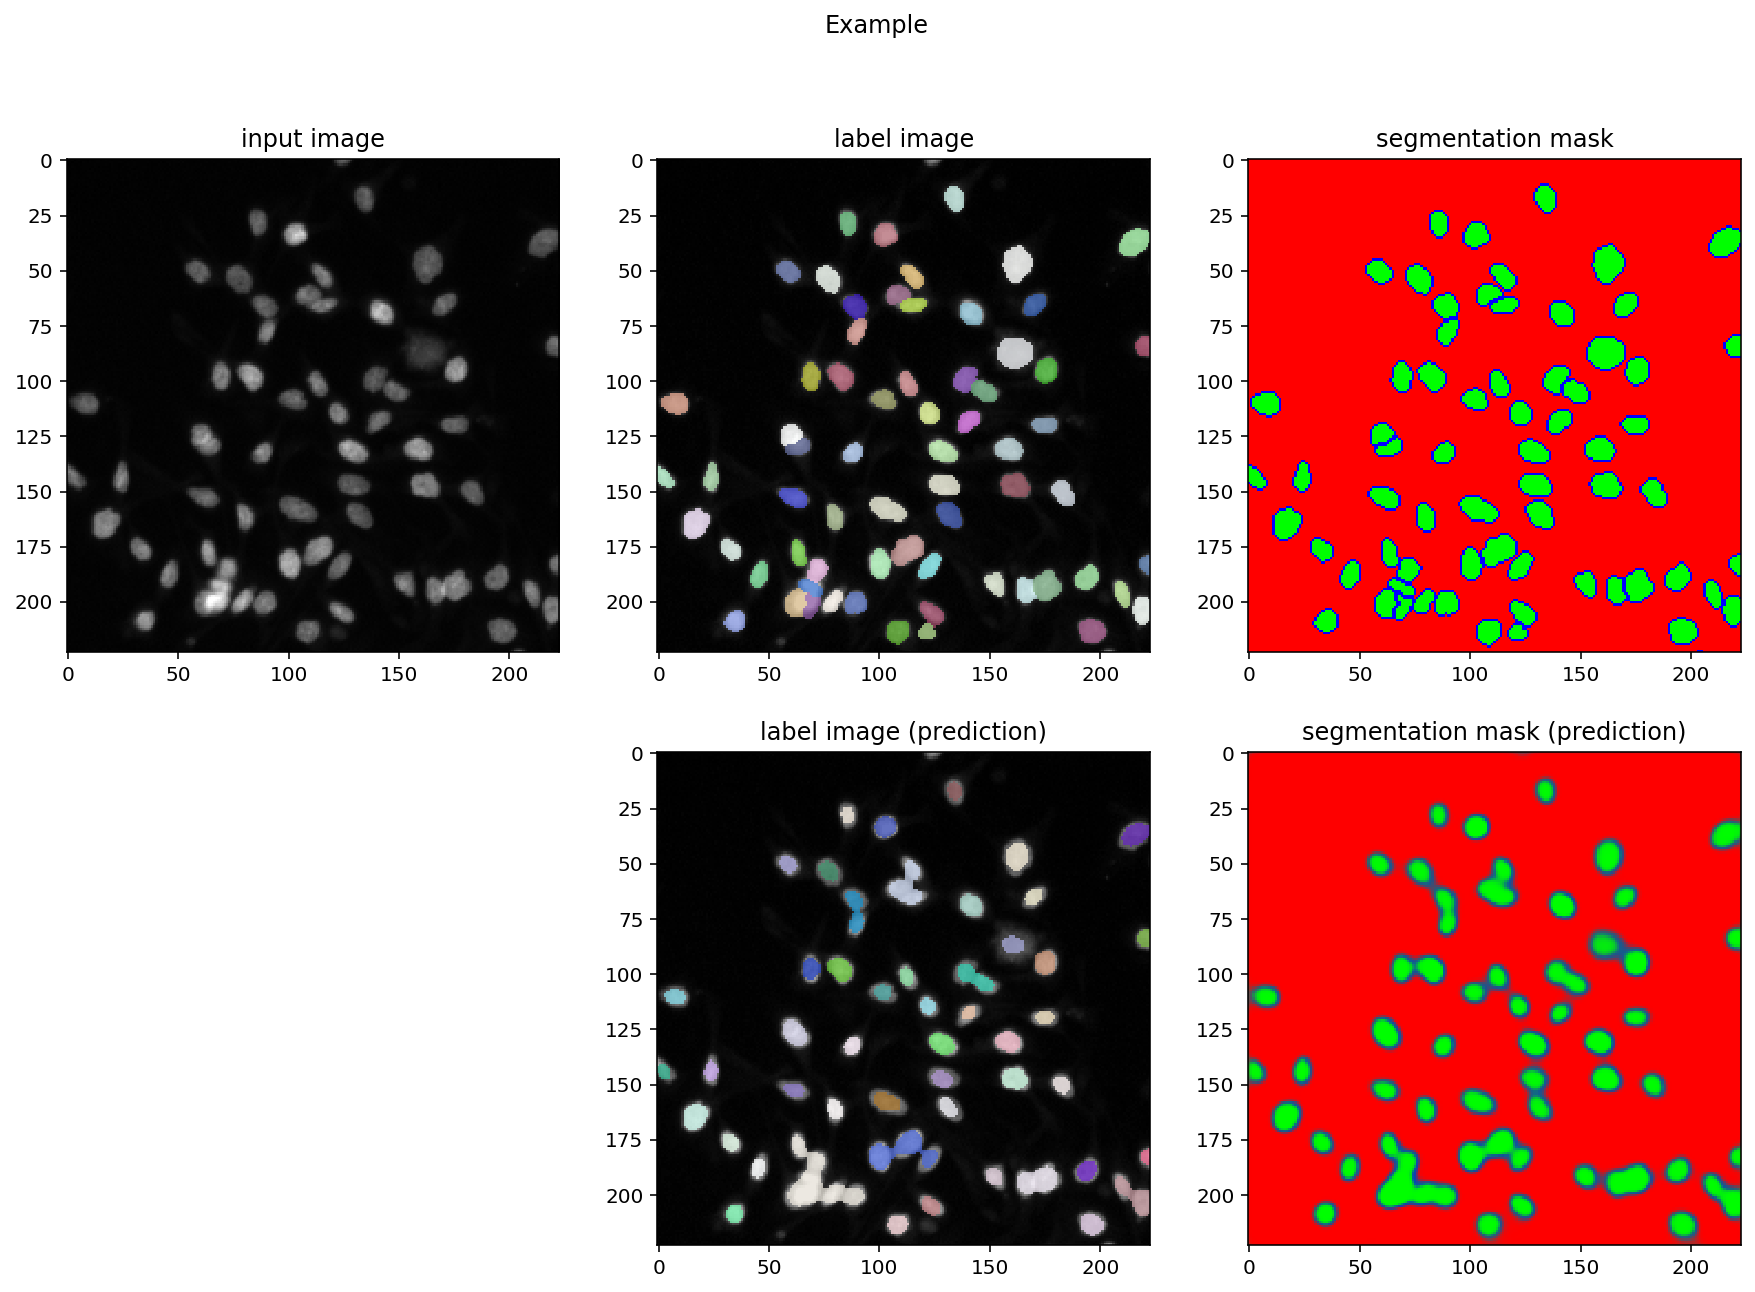

In [37]:
from skimage.measure import label

# threshold inner (green) and find connected components
lbl_pred = label(mask_pred[...,1] > 0.7)

lbl_show = render_label(lbl, img=img, alpha=0.75)
lbl_pred_show = render_label(lbl_pred, img=img, alpha=0.75)

fig, ((a0,a1,a2),(b0,b1,b2)) = plt.subplots(2,3,figsize=(15,10))
a0.imshow(img,cmap='gray'); a0.set_title('input image')
a1.imshow(lbl_show);        a1.set_title('label image')
a2.imshow(mask);            a2.set_title('segmentation mask')
b0.axis('off')
b1.imshow(lbl_pred_show);   b1.set_title('label image (prediction)')
b2.imshow(mask_pred);       b2.set_title('segmentation mask (prediction)')
fig.suptitle("Example")
None;

## Tile iterator to process large images

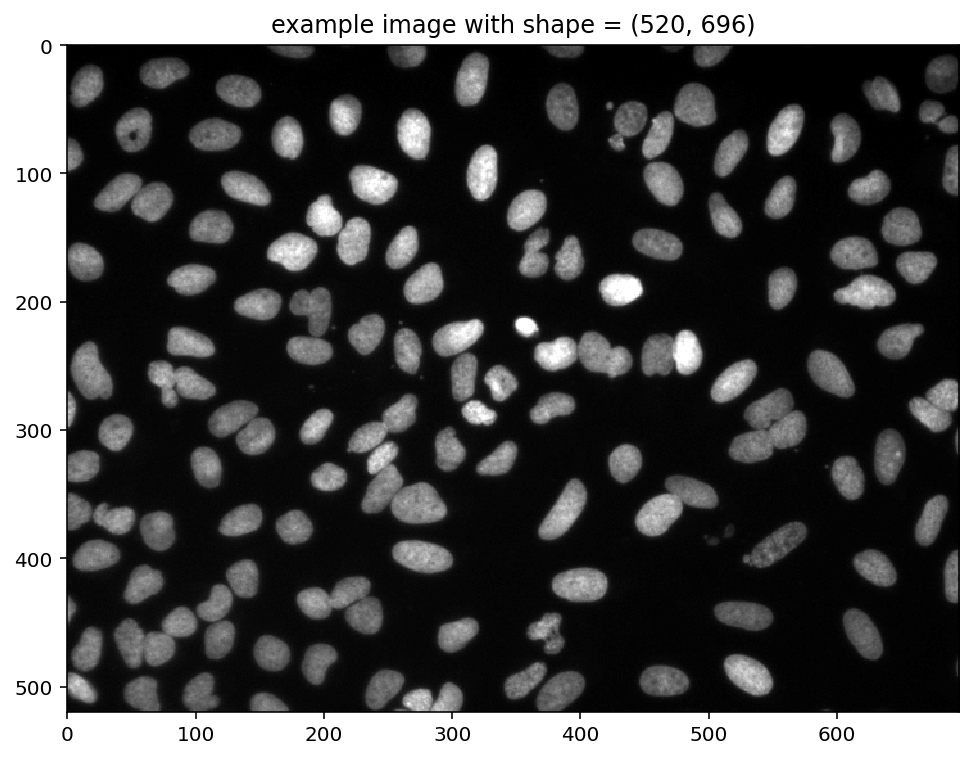

In [38]:
img = imread('data/dsb2018/test/images/5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed.tif')
img = normalize(img, 1,99.8)
plt.figure(figsize=(8,8))
plt.imshow(img, clim=(0,1), cmap='gray')
plt.title(f"example image with shape = {img.shape}");

block_sizes = (8, 8)
n_block_overlaps = (3, 5)
n_tiles = (3, 5)


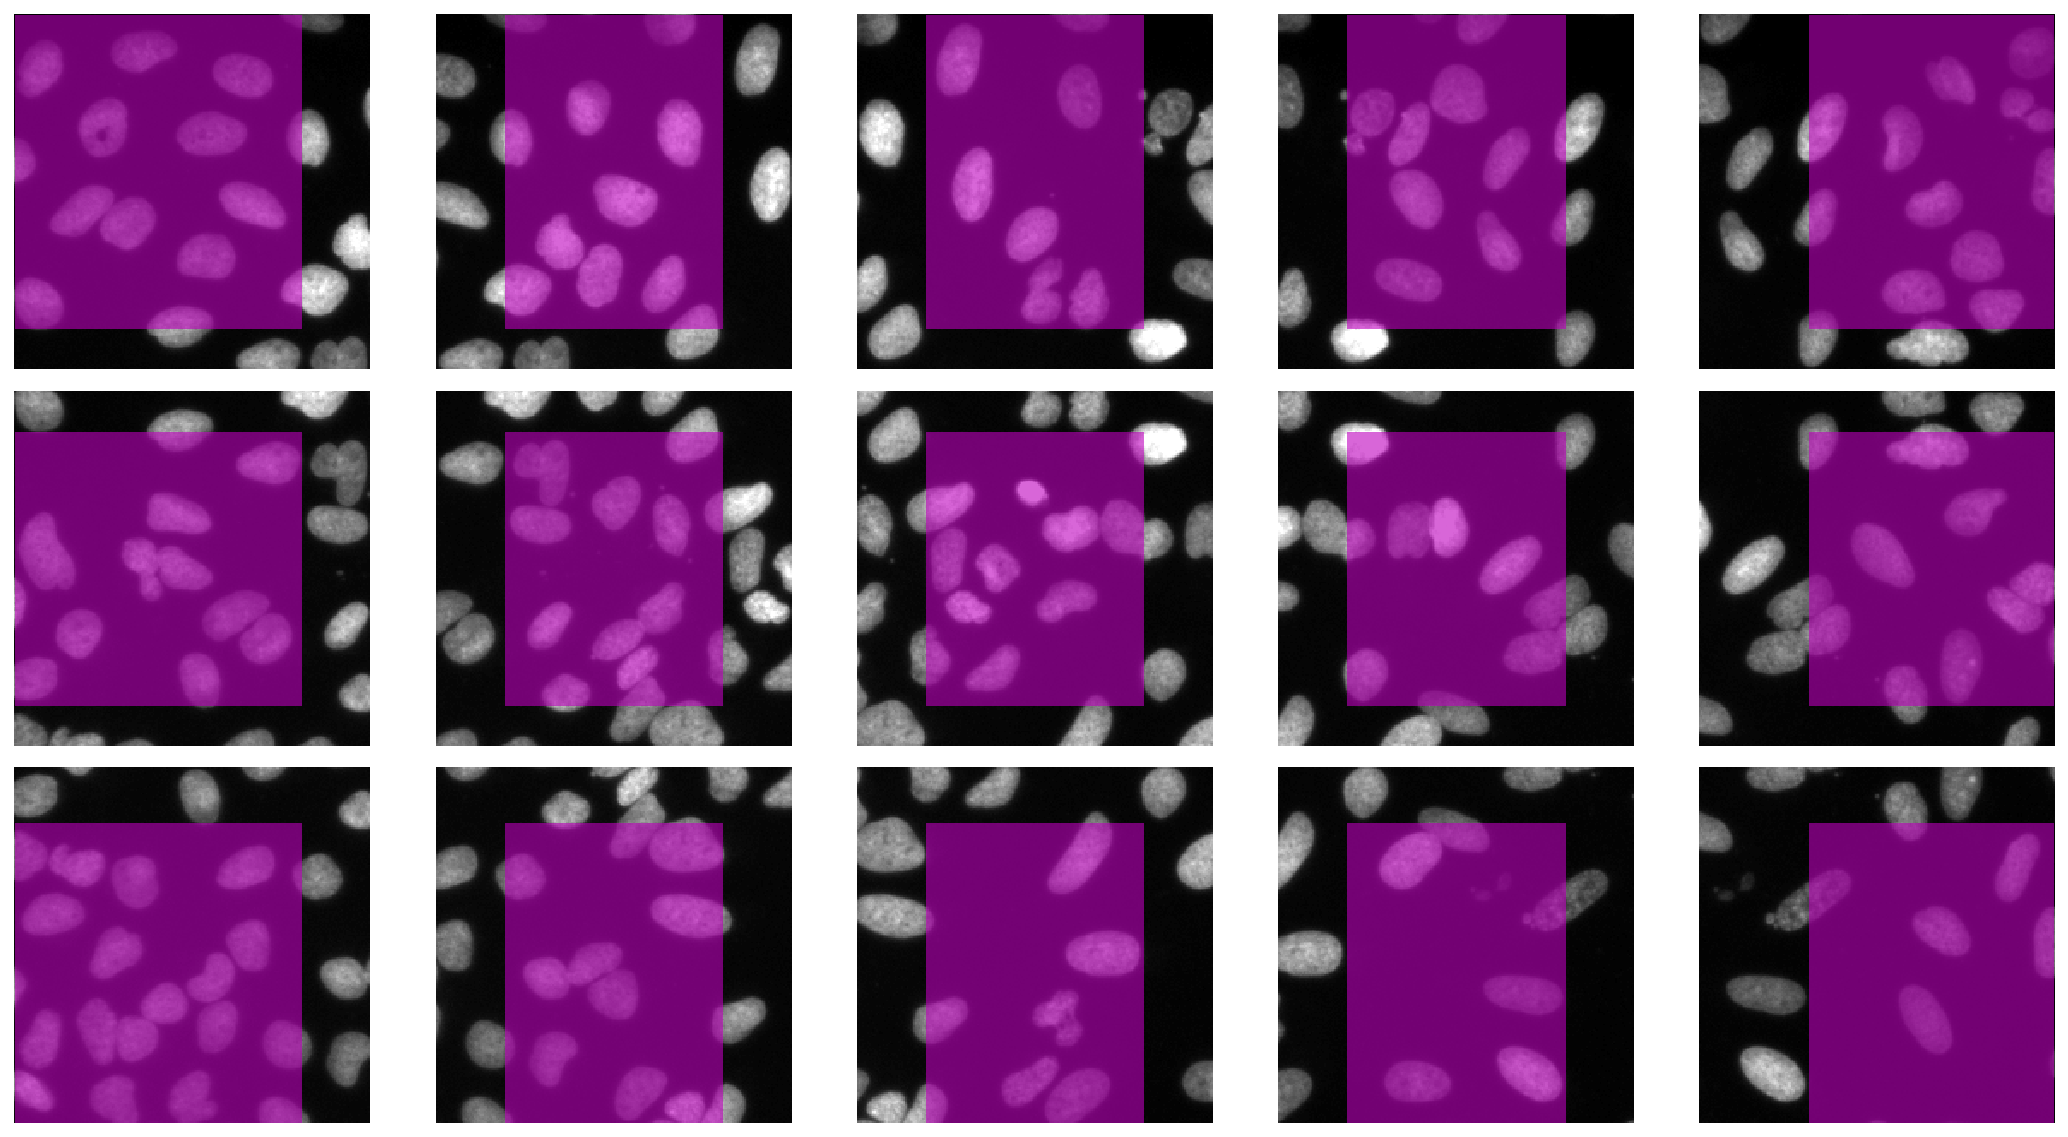

In [39]:
from csbdeep.internals.predict import tile_iterator
import matplotlib.patches as patches

def process(x):
    return model.predict(x, axes='YX')

img_processed       = process(img)
img_processed_tiled = np.empty_like(img_processed)

###

block_sizes = (8,8)
n_block_overlaps = (3,5)
n_tiles = (3,5)

print(f"block_sizes = {block_sizes}")
print(f"n_block_overlaps = {n_block_overlaps}")
print(f"n_tiles = {n_tiles}")

fig, ax = plt.subplots(*n_tiles, figsize=(15,8))
ax = ax.ravel()
[a.axis('off') for a in ax]
i = 0

for tile,s_src,s_dst in tile_iterator(img, n_tiles, block_sizes, n_block_overlaps, guarantee='size'):
    # tile is padded; will always start and end at a multiple of block size
    # tile[s_src] removes the padding (shown in magenta)
    # the slice s_dst denotes the region where tile[s_src] comes from
    
    # process tile, crop the padded region from the result and put it at its original location
    img_processed_tiled[s_dst] = process(tile)[s_src]
            
    ax[i].imshow(tile, clim=(0,1), cmap='gray')
    rect = patches.Rectangle( [s.start        for s in reversed(s_src)],
                             *[s.stop-s.start for s in reversed(s_src)],
                              edgecolor='none',facecolor='m',alpha=0.6)
    ax[i].add_patch(rect)    
    i+=1

plt.tight_layout()

assert np.allclose(img_processed, img_processed_tiled)
None;

# StarDist

- [Notebook: Prediction for big data](https://nbviewer.jupyter.org/github/mpicbg-csbd/stardist/blob/dev/examples/other2D/predict_big_data.ipynb)
- [Notebook: ImageJ ROI Export](https://nbviewer.jupyter.org/github/mpicbg-csbd/stardist/blob/dev/examples/other2D/export_imagej_rois.ipynb)